In [1]:
pip install lazrs

/Users/Ev1/.zshenv:.:1: no such file or directory: /Users/Ev1/.cargo/env
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install open3d

/Users/Ev1/.zshenv:.:1: no such file or directory: /Users/Ev1/.cargo/env
Note: you may need to restart the kernel to use updated packages.


In [3]:
import laspy
import numpy as np
from sklearn import linear_model
import open3d as o3d
import os
import matplotlib.pyplot as plt

In [4]:

def read_las_file(las_path):
    # Read the LAS file
    las_data = laspy.read(las_path)

    # Extract the points and classifications from the LAS file
    points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()

    # Create an Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    #return as point cloud
    return pcd


pcd = read_las_file("off-ground-points.las")

In [5]:
o3d.visualization.draw_geometries([pcd])
num = len(pcd.points)

In [6]:
#downsample cloud
downpcd = pcd.voxel_down_sample(voxel_size=0.1)
num2 = len(downpcd.points)
print(f'Number of points after downsampling reduced from {num} to {num2}')
print(f' {100-(num2/num * 100)} % less points')
#o3d.visualization.draw_geometries([downpcd])

Number of points after downsampling reduced from 18919717 to 3305786
 82.52729678779022 % less points


In [7]:
#statistical outlier removal

cld, ind = downpcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.2)
num3 = len(cld.points)
print(f'reduced from {num2} to {num3} points')
print(f' {100-(num3/num2 * 100)} % less points')

reduced from 3305786 to 2587112 points
 21.739882738931072 % less points


In [8]:

points = np.asarray(cld.points)

# define slice levels
z_levels = [0.1, 0.4, 0.7]  

# Create an empty point cloud for the slices
slices_pcd = o3d.geometry.PointCloud()

for z in z_levels:
    # Define a threshold for the slice thickness
    z_threshold = 0.05
    # Select points that fall within the Z level +/- threshold
    slice_mask = (points[:, 2] > (z - z_threshold)) & (points[:, 2] < (z + z_threshold))
    slice_points = points[slice_mask, :3]  # Keep XYZ coordinates for the slice
    
    # Append slice points to the slices_pcd point cloud
    if len(slice_points) > 0:
        slice_pcd = o3d.geometry.PointCloud()
        slice_pcd.points = o3d.utility.Vector3dVector(slice_points)
        slices_pcd += slice_pcd  # Merge the slice into the main slices point cloud

# Visualize all slices together
o3d.visualization.draw_geometries([slices_pcd])


In [9]:
# We find clusters
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(slices_pcd.cluster_dbscan(eps=0.5, min_points=5, print_progress=True))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
slices_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.                     ] 2%
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 368
Precompute neighbors.[========point cloud has 368 clusters    ] 75%
Precompute neighbors.[========================================] 100%


In [10]:
o3d.visualization.draw_geometries([slices_pcd])

In [11]:
# Get individual point clouds
point_clouds = []
for cluster_label in range(max_label + 1):
    
    cluster_indices = np.where(labels == cluster_label)[0]
    
    cluster_points = slices_pcd.select_by_index(cluster_indices)

    #We only include the individual point cloud if over a certain size
    cluster_size = len(cluster_points.points)
    if(20< cluster_size < 100):
        point_clouds.append(cluster_points)
len(point_clouds)

161

In [12]:
# Initialize an empty point cloud for the combined data
combined_cloud = o3d.geometry.PointCloud()

# Iterate over each individual point cloud and append its data to the combined point cloud
for pcd in point_clouds:
    combined_cloud += pcd

# Visualize the combined point cloud
o3d.visualization.draw_geometries([combined_cloud])



In [13]:
# Initialize an empty list to store 2D points of all clusters
clusters_2d_points = []

# Iterate over each individual point cloud cluster
for pcd in point_clouds:
    # Convert to numpy array
    points = np.asarray(pcd.points)
    # Flatten the Z-coordinate and keep as separate clusters
    points_2d = points[:, :2]
    clusters_2d_points.append(points_2d)

# Now `clusters_2d_points` is a list of 2D arrays where each array corresponds to a cluster

len(clusters_2d_points)


161

In [14]:

# Loop over the clusters and apply RANSAC circle fitting
accepted_circles = []
for i, points_2d in enumerate(clusters_2d_points):
    circle, inlier_mask, _ = fit_circle_ransac(points_2d, min_inlier_ratio=0.5)
    if circle is not None:
        accepted_circles.append(circle)
        print(f"Cluster {i+1}: Circle detected with center at ({circle[0]:.2f}, {circle[1]:.2f}) and radius {circle[2]:.2f}")
    else:
        print(f"Cluster {i+1}: No acceptable circle found")

# Now `accepted_circles` contains the parameters of the circles that met the inlier ratio criterion
len(accepted_circles)

NameError: name 'fit_circle_ransac' is not defined

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

def fit_circle_ransac(points, iterations=1000, inlier_thresh=0.025, min_inliers=20, min_inlier_percentage=0.7):
    best_circle = None
    best_inlier_count = 0
    best_inlier_mask = None
    best_inlier_mse = float('inf')
    num_points = len(points)
    
    # Helper function to calculate the distance from points to the circle
    def point_to_circle_dist(points, circle):
        center_x, center_y, radius = circle
        return np.abs(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2) - radius)

    for _ in range(iterations):
        # Randomly select 3 points to define a circle
        sample_points = points[np.random.choice(points.shape[0], 3, replace=False), :]
        circle = fit_circle_least_squares(sample_points)
        
        # Calculate distances from all points to the circle
        distances = point_to_circle_dist(points, circle)
        
        # Determine inliers based on the distance threshold
        inlier_mask = distances < inlier_thresh
        inlier_count = np.sum(inlier_mask)
        
        if inlier_count > 0:
        
            # Calculate mean squared error for inliers
            inlier_mse = mean_squared_error(np.zeros(np.sum(inlier_mask)), distances[inlier_mask])

            inlier_percentage = inlier_count / num_points
            # Update best circle if this one has more inliers and a lower MSE
            if inlier_count > best_inlier_count and inlier_count >= min_inliers and inlier_mse < best_inlier_mse and inlier_percentage > min_inlier_percentage:
                best_circle = circle
                best_inlier_count = inlier_count
                best_inlier_mask = inlier_mask
                best_inlier_mse = inlier_mse
            
    return best_circle, best_inlier_mask

# Helper function for least squares circle fit
def fit_circle_least_squares(points):
    # Your least squares circle fitting logic
    # For now, let's just use the mean of the points as the center and the average distance to the center as the radius
    center_x = np.mean(points[:, 0])
    center_y = np.mean(points[:, 1])
    radius = np.mean(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2))
    return (center_x, center_y, radius)

def plot_result(points_2d, inlier_mask, circle_parameters):
    print("Best fit circle center: ({}, {}) with radius {}".format(*circle_parameters))
    # Begin plotting
    fig, ax = plt.subplots()
    ax.scatter(points_2d[:, 0], points_2d[:, 1], color='blue', label='Outliers')
    ax.scatter(points_2d[inlier_mask, 0], points_2d[inlier_mask, 1], color='red', label='inliers')

    [center_x, center_y, radius] = circle_parameters
    circle_plot = plt.Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_artist(circle_plot)
    
    




"""


# test script 
index = 5
best_circle, inliers = fit_circle_ransac(clusters_2d_points[index])
if(best_circle):
    plot_result(clusters_2d_points[index], inliers, best_circle)
"""

'\n\n\n# test script \nindex = 5\nbest_circle, inliers = fit_circle_ransac(clusters_2d_points[index])\nif(best_circle):\n    plot_result(clusters_2d_points[index], inliers, best_circle)\n'

Best fit circle center: (23.393690740740748, 11.468709259259263) with radius 0.2474491361070116
Best fit circle center: (4.936413968253969, -17.494302539682536) with radius 0.1762299847400326
Best fit circle center: (20.210691666666673, 12.794299652777779) with radius 0.2909170793491252
Best fit circle center: (14.121328417397663, -6.619446736111108) with radius 0.2286243181003834
Best fit circle center: (11.034038369355272, -5.602102023854839) with radius 0.2574985010122269
Best fit circle center: (8.102703078669615, -11.31217799009982) with radius 0.19132725976515164
Best fit circle center: (9.075947222222224, -33.615926587301594) with radius 0.2906955212915441
Best fit circle center: (-3.9408722222222217, -36.03353055555555) with radius 0.24239400350001764
Best fit circle center: (-10.927317564102566, -24.06415209401709) with radius 0.18639578496927825


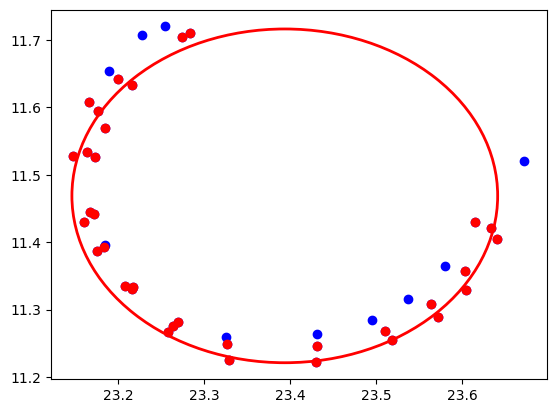

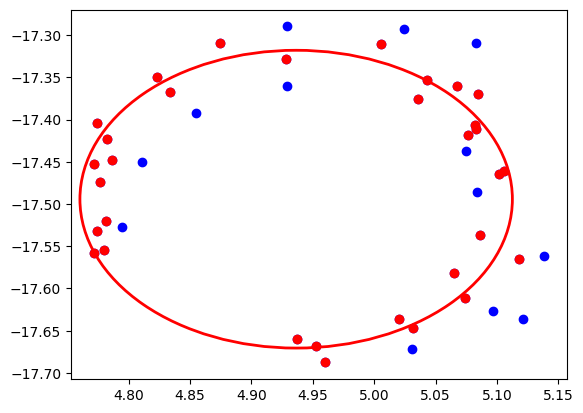

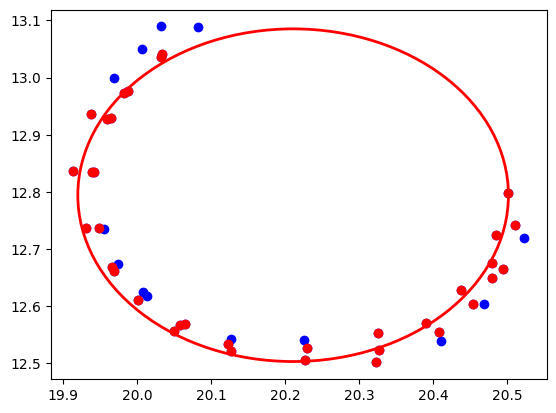

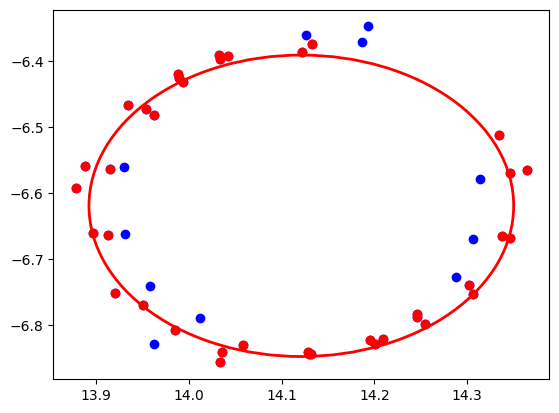

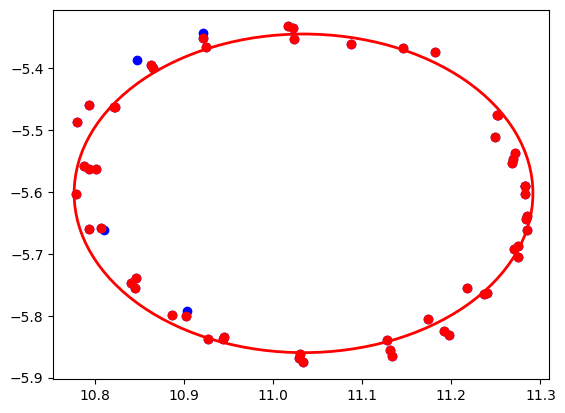

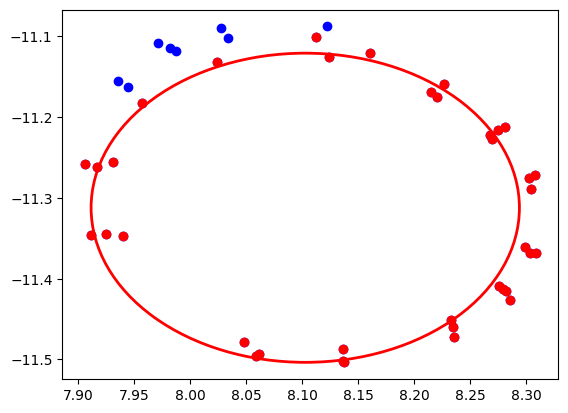

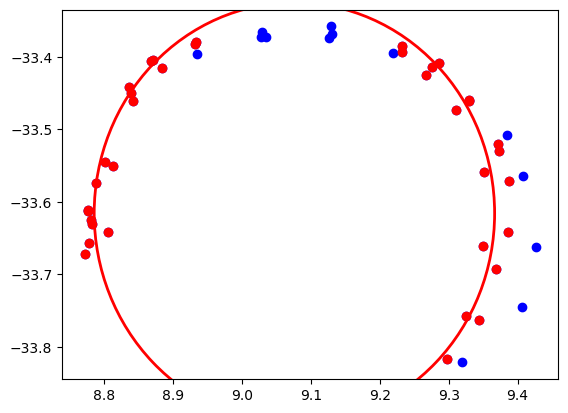

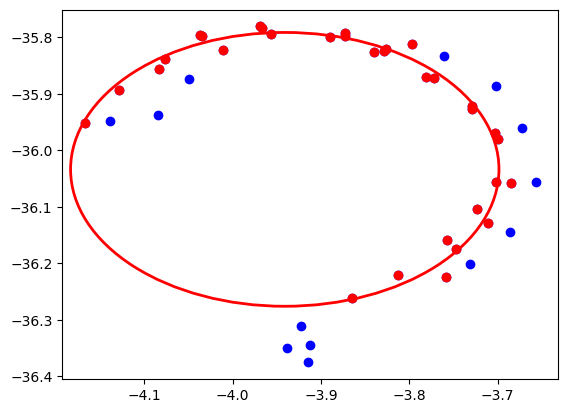

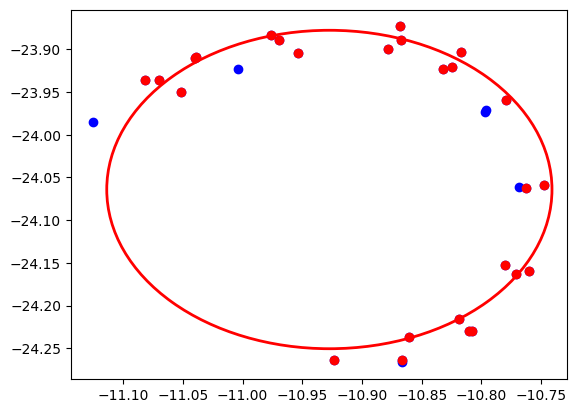

In [16]:
result = []
for cluster in clusters_2d_points:
    best_circle, inliers = fit_circle_ransac(cluster)
    if(best_circle):
        plot_result(cluster, inliers, best_circle)
        result.append(best_circle)

In [ ]:
import open3d as o3d

def create_bounding_box(center, extent):
    obb = o3d.geometry.OrientedBoundingBox()
    obb.center = center
    obb.extent = extent
    return obb

# Read the point cloud data
original_pcd = read_las_file("off-ground-points.las")

# Define the extent of the bounding box
extent = (3, 3, 15)  # Modify as needed

bounding_boxes = []
for circle in result:
    # Create the bounding box using the circle's center
    BB = create_bounding_box((circle[0], circle[1], 0.0), extent)
    bounding_boxes.append(BB)

# Visualize all bounding boxes with the original point cloud
o3d.visualization.draw_geometries([original_pcd, *bounding_boxes], "Point Cloud with All Bounding Boxes")


In [22]:
inside_pcds = []
for BB in bounding_boxes:
    inside_points_index = BB.get_point_indices_within_bounding_box(original_pcd.points)
    inside_pcd = original_pcd.select_by_index(inside_points_index)
    inside_pcds.append(inside_pcd)

# Visualize the points inside each bounding box separately
for inside_pcd, BB in zip(inside_pcds, bounding_boxes):
    o3d.visualization.draw_geometries([inside_pcd, BB], "Points Within a Bounding Box")
